In [1]:
from src import uilc
import numpy as np
import math
import matplotlib.pyplot as plt

# Examples 

## Linear Array

system setting

In [2]:
s = 1.11
W = 0.2
H = 0.05

## ESC method

Using expanded Sparrow's Criterion

In [3]:
esc_n = uilc.esc.get_nmax(s, W, H)
esc_d = uilc.esc.coefficient(s ,esc_n) * H
esc_arr = uilc.utils.uniformarray(esc_d, esc_n) 

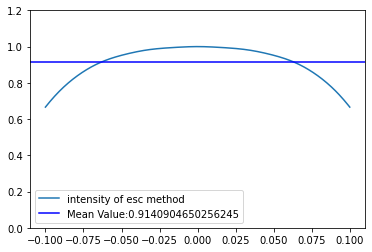

In [4]:
esc_xline = np.linspace(-W/2, W/2 , 400)
esc_intensity = uilc.utils.lambertian_distribution(esc_xline, np.array([[[0]]]), esc_arr, s, H)
esc_y = esc_intensity[0][0]
esc_y = esc_y/esc_y.max()
plt.plot(esc_xline, esc_y, label="intensity of esc method")
plt.axhline(y=esc_y.mean(), color='b', label="Mean Value:{}".format(esc_y.mean()))
plt.ylim(0, 1.2)
plt.legend()
plt.show()

## BC-expansion method

This method optimize array with matching boundary-center intensity contribution of each LEDs given system.

In [5]:
bc_xe = uilc.disop.find_xe(W, H, s)
bc_xm = uilc.disop.find_xm(W, H, s, bc_xe)
bc_esc_n = uilc.disop.get_n_esc_max(s, H, bc_xm, bc_xe)
bc_esc_d = uilc.esc.coefficient(s, bc_esc_n) * H
bc_esc_arr = uilc.utils.uniformarray(bc_esc_d, bc_esc_n, 1)
bc_arr = uilc.disop.get_bc_expansion(bc_esc_arr, s, H, W, bc_xe, bc_xm)

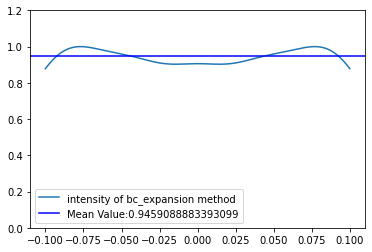

In [6]:
# Intensity graph
bc_xline = np.linspace(-W/2, W/2 , 400)
bc_intensity = uilc.utils.lambertian_distribution(bc_xline, np.array([[[0]]]), bc_arr, s, H)
bc_y = bc_intensity[0][0]
bc_y = bc_y/bc_y.max()
plt.plot(bc_xline, bc_y, label="intensity of bc_expansion method")
plt.axhline(y=bc_y.mean(), color='b', label="Mean Value:{}".format(bc_y.mean()))
plt.ylim(0, 1.2)
plt.legend()
plt.show()

## Discretize solve of integral equation

$n_{app} =$ Number of LEDs in bc expansion method

It is an approximation number. Maybe $n_{app}\pm 1$ would be more apropriate but mostly it is well fitted.

In [7]:
napp = bc_arr.shape[1]

### Direct solve

In [8]:
ds_rho, ds_position, ds_F = uilc.disop.solve_system(s, W, H)
# Normalization
ds_lamb = napp * ds_rho.size / (W*ds_rho.sum())
ds_rho = ds_lamb * ds_rho

$$\delta(x-a) \approx \frac{1}{\sigma \sqrt{2\pi}} \exp(- \frac{(x-a)^2}{2 \sigma^2})$$


$$\sigma = \frac{W}{2 n k}$$

$k$ is a coefficient.



In [9]:
ds_k = math.sqrt(2)*0.9
ds_sigma = W/(2*napp * ds_k)

In [10]:
ds_arr = uilc.disop.nomarlization_lq(bc_arr,  ds_position, ds_rho, napp, ds_sigma , W)

LED location and $\vec{\rho}$ compare

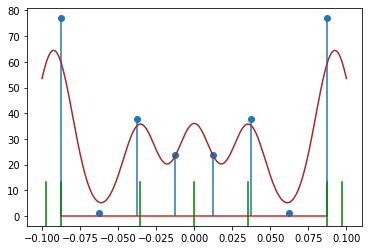

In [11]:
ds_pos_xline = np.linspace(-W/2, W/2, 400)
ds_pos_y = uilc.utils.gauss_distribution(ds_pos_xline, np.array([[[0]]]), ds_arr, ds_sigma )

plt.stem(ds_position, ds_rho)
plt.plot(ds_pos_xline, ds_pos_y[0][0], color="brown")
for x in ds_arr[0,0:napp][0:napp,0]:
    plt.axvline(x, ymin=0, ymax=0.2 , color="green")    
plt.show()

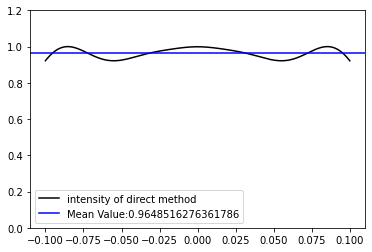

In [12]:
ds_xline = np.linspace(-W/2, W/2 , 400)
ds_intensity = uilc.utils.lambertian_distribution(ds_xline, np.array([[[0]]]), ds_arr, s, H)
ds_y = ds_intensity[0][0]
ds_y = ds_y/ds_y.max()
plt.plot(ds_xline, ds_y, label="intensity of direct method", color="black")
plt.axhline(y=ds_y.mean(), color='b', label="Mean Value:{}".format(ds_y.mean()))
plt.ylim(0, 1.2)
plt.legend()
plt.show()

### NNLS solve

Non-negative least square solve


In [13]:
nnls_n = 1000
threshold = 10
nnls_rho, nnls_position, nnls_F = uilc.disop.solve_system(s, W, H, nnls_n, method="nnls")
nnls_lamb =  (napp+1) * nnls_rho.size / (W*nnls_rho.sum())
nnls_rho = nnls_lamb * nnls_rho


In [14]:
nnls_position = nnls_position[np.argwhere(nnls_rho>threshold)]
nnls_rho= nnls_rho[nnls_rho>threshold]

In [15]:
#fac = 0.7353 Boundary value is not apropriate for finding optimization of 2nd LED location from boundary
fac=0.75
delt_alzero = (1-fac) * nnls_rho[0] *0.3 #< threshold 
nnls_rho[0] *= fac
nnls_rho[nnls_rho.size-1] *= fac

#------------------------
#delt_alzero = 10
nnls_rho = np.insert(nnls_rho, 1, delt_alzero)
nnls_rho = np.insert(nnls_rho, nnls_rho.size-1, delt_alzero)

al = 1
be = 2
gam = al+be
d1 = (al*nnls_position[0] + be* nnls_position[1])/gam
k = nnls_position.size
d2 = (al*nnls_position[k-1] +  be* nnls_position[k-2])/gam


nnls_position = np.insert(nnls_position, 1, d1)
nnls_position = np.insert(nnls_position, nnls_position.size-1, d2)
#----------------------------------------------
nnls_k = math.sqrt(2)*0.92
nnls_sigma = W/(2*(napp+1)*nnls_k)

In [16]:
nnls_d = uilc.esc.coefficient(s, 4)
nnls_d * H
nnls_init0_esc_arr = uilc.utils.uniformarray(nnls_d*H, 4)
nnls_init0_bc_arr = uilc.disop.get_bc_expansion(nnls_init0_esc_arr, s, H, W, bc_xe, bc_xm)

In [17]:
nnls_arr = uilc.disop.nomarlization_lq(nnls_init0_bc_arr,  nnls_position, nnls_rho, napp+1, nnls_sigma, W)

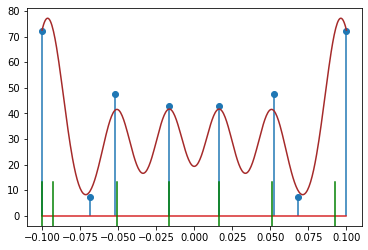

In [18]:
nnls_pos_xline = np.linspace(-W/2, W/2, 400)
nnls_pos_y = uilc.utils.gauss_distribution(nnls_pos_xline, np.array([[[0]]]), nnls_arr, nnls_sigma )

plt.stem(nnls_position, nnls_rho)
plt.plot(nnls_pos_xline, nnls_pos_y[0][0], color="brown")
for x in nnls_arr[0,0:napp][0:napp,0]:
    plt.axvline(x, ymin=0, ymax=0.2 , color="green")    
plt.show()

In [26]:
nnls_arr[0,0:8][0:8,0] = np.sort((nnls_arr[0,0:8][0:8,0]))

In [28]:
nnls_arr*1000

array([[[-100.01660668,    0.        ],
        [ -92.66291496,    0.        ],
        [ -50.85657627,    0.        ],
        [ -16.39986314,    0.        ],
        [  16.39986314,    0.        ],
        [  50.85657627,    0.        ],
        [  92.66291496,    0.        ],
        [ 100.01660668,    0.        ]]])

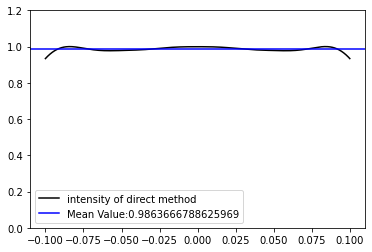

In [19]:
nnls_xline = np.linspace(-W/2, W/2 , 400)
nnls_intensity = uilc.utils.lambertian_distribution(ds_xline, np.array([[[0]]]), nnls_arr, s, H)
nnls_y = nnls_intensity[0][0]
nnls_y = nnls_y/nnls_y.max()
plt.plot(nnls_xline, nnls_y, label="intensity of direct method", color="black")
plt.axhline(y=nnls_y.mean(), color='b', label="Mean Value:{}".format(nnls_y.mean()))
plt.ylim(0, 1.2)
plt.legend()
plt.show()

## Compare

In [20]:
t_d = uilc.esc.coefficient(s, 8)* H
t_esc_arr = uilc.utils.uniformarray(t_d , 8)
esc_8_intensity = uilc.utils.lambertian_distribution(ds_xline, np.array([[[0]]]), t_esc_arr , s, H)
bc_8_intensity = uilc.utils.lambertian_distribution(ds_xline, np.array([[[0]]]), nnls_init0_bc_arr, s, H)

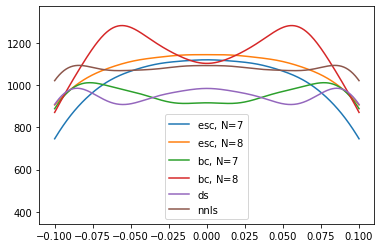

In [21]:
xline = np.linspace(-W/2, W/2 , 400)
plt.plot(xline, esc_intensity[0][0], label="esc, N=$7$")
plt.plot(xline, esc_8_intensity[0][0], label="esc, N=$8$")
plt.plot(xline, bc_intensity[0][0], label="bc, N=$7$")
plt.plot(xline, bc_8_intensity[0][0], label="bc, N=$8$")
plt.plot(xline, ds_intensity[0][0], label="ds")
plt.plot(xline, nnls_intensity[0][0], label="nnls")
vmin = esc_8_intensity[0][0].max()*0.3
vmax = esc_8_intensity[0][0].max()*1.2
plt.ylim(vmin, vmax)
plt.legend()
plt.show()

In [29]:
print((esc_8_intensity[0][0]).std()/(esc_8_intensity[0][0]).mean())
print((nnls_intensity[0][0]).std()/(nnls_intensity[0][0]).mean())

0.06008274034429879
0.011648876939145408
